In [47]:
from IPython.core.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# 1. Data sorting
    - Join the location of all journalists who has GitHub in Github_Analysis.csv
    - Screen out all US journalists from these sources.

In [4]:
import pandas as pd
df = pd.read_csv('Data_Journalism.csv')
dfs = pd.read_csv('Github_Analysis.csv')

In [13]:
# 这里不封函数了 但是说明另外一个问题 以后爬数据不能偷懒 其他信息最好一起写进去 不然整理起来太麻烦
Location = []
for i in df['Name']: # 有地点的df
    for n in dfs['Name']: # 没有地点的dfs
        if i == n:
            L = dfs[dfs['Name']==i]['Location'].tolist()[0] # 变成str再写进list 然后再写进去DataFrame
            Location.append(L) 
            
# 把地点和有GitHub的记者一一对应起来
dfs.insert(0, 'Location', Location)


In [10]:
# 清理出所有的美国的信息，去掉其他的 并写成DataFrame

for i in dfs['Location']:
    if 'United States' not in i:
        number = dfs[dfs['Location'] == i]['Unnamed: 0'].tolist()[0] # 运用index定位
        dfs.drop([number], inplace=True)

# 2. Data visualization
    - Count the number of American cities
    - Count the average number of programming days on GitHub in all US cities

# What is the frequency of the city where American data journalists are located?

It’s clear that New York has the highest frequency in all American cities. Then let's analyze it further

In [2]:
from matplotlib import pyplot as plt
import pygal
from pyecharts import Bar
import pyecharts

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "/Users/lichenxi/venv/lib/python3.6/site-packages/lml/utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


In [16]:
# 漏斗图
def Louchart(k,v):
    fl = pyecharts.Funnel("Average contribution in US TOP 8", title_pos='center', width=900, height=600)
    fl.add("add", k, v, is_label_show=True, label_pos='inside',legend_pos='left',legend_orient='vertical',label_text_color='white')
    fl.render("Funnel-low.html")
    return fl


# 交互式bar chart
def Interbar(i):
    bar = Bar("Location by number of data journalism")
    bar.add("by number", i.index, i.Location)
    return bar


In [40]:
# 生成bar chart
country = pd.DataFrame(dfs["Location"].value_counts())
country.head()
Interbar(country)

# What is mean of programming days in each US cities

In [48]:
# 漏斗生成
pd_df2 = dfs.groupby(['Location'])['Times'].mean().reset_index().sort_values("Times",ascending=False)[:8]
attr = pd_df2.Location
v2 = pd_df2.Times
Louchart(attr,v2)

In [20]:
import plotly
import plotly.graph_objs as go

In [21]:
# offline 不好展示 暂时不用
pd_df2 = dfs.groupby(['Location'])['Times'].mean().reset_index().sort_values("Times",ascending=False)
data = [go.Bar(x=pd_df2.Location,
            y=pd_df2.Times)]
plotly.offline.plot(data, filename='country_with_average_times_bar')

# 在jupyter notebook上看不到

/Users/lichenxi/venv/lib/python3.6/site-packages/plotly/offline/offline.py:608: UserWarning:

Your filename `country_with_average_times_bar` didn't end with .html. Adding .html to the end of your file.



'file:///Users/lichenxi/Assignment/country_with_average_times_bar.html'

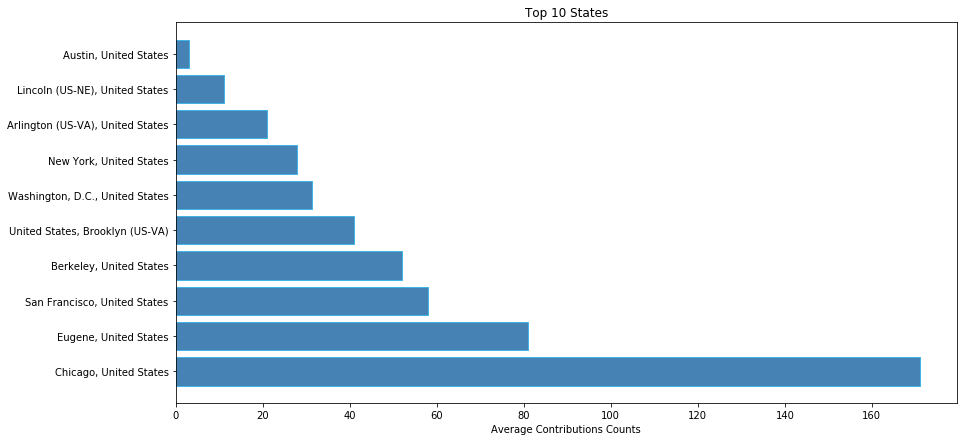

In [92]:
# 很有趣的是 最大mean居然不是New York 原来纽约记者有GitHub的虽然多，但是很多人每年的编程天数并不高 所以mean的值并不高
# 但是Chicago一个老哥就干了160天 没有人拖后腿 所以一支独秀了
# 从这个角度再来看，突然发现美国的数据新闻记者虽然多，但是其实GitHub contributions are not the most one, whether times or whole contributions

pd_df2 = dfs.groupby(['Location'])['Times'].mean().reset_index().sort_values("Times",ascending=False)[:10]
fig = plt.figure(figsize=(14,7)) #adjust size
plt.barh(pd_df2.Location,pd_df2.Times, color = 'steelblue',edgecolor = '#40b4e5') #change color of the bars
plt.title('Top 10 States') #plot title and label name
plt.xlabel('Average Contributions Counts')
# plt.ylabel('counts')
plt.show()


- It's interesting that the biggest mean isn't New York. Actually, although many New York reporters have GitHub, many people don't have habit of programming. So pull down the overall level and the value of mean is not high.

- A brother in Chicago has been working for 160 days. No one is dragging his legs. So a solo show. Most importantly, there is an issue, not the city with the most data journalists will have the most contributions.
- ps：Because the amount of data is relatively small, such analysis is not reasonable, but can be extended to further topics.


# For further research, we continue to crawl the tweet texts of all American journalists.

## Data cleanup; Filter out information from all US journalists

In [11]:
import pandas as pd
df = pd.read_csv('Data_Journalism.csv')# 还是需要美国的
# 清理出所有的美国的信息，去掉其他的 并写成DataFrame
for i in df['Location']:
    if 'United States' not in i:
        number = df[df['Location'] == i]['Unnamed: 0'].tolist()[0] # 运用index定位
        df.drop([number], inplace=True)
df['Twitter'] #46条美国推特网址

## Crawling Twitter text more than 4,000 tweets

In [ ]:
# 爬取单人的并封装函数
from selenium import webdriver
import time
browser = webdriver.Chrome() 
browser.get('http://www.twitter.com/smelendez')

# 翻页五次 每人100条推特信息 
def T_scraper(i):
    browser.get(i)
    for i in range(5):
        time.sleep(1)
        browser.execute_script("window.scrollTo(0,100000);")# 不管翻页多大也只是往下拉 每次最多多拿20个elments
        time.sleep(0.5)

    element = browser.find_elements_by_css_selector('.TweetTextSize.TweetTextSize--normal') 
    global All_T_text
    All_T_text = []
    for i in element:
        T_text = i.text # 直接这里用split的话 后面没办法保留需要的词
        
        All_T_text.append(T_text)
    
    return All_T_text

In [ ]:
# 爬取46条网址并全部切割以后放入All_words
from selenium.common.exceptions import WebDriverException

browser = webdriver.Chrome() 
All_words = []
for i in T_list:
    try:
        T_scraper(i)
        All_words.extend(All_T_text)
    except WebDriverException:
        print(i)
# 把所有words写进txt
f = open('test.txt','w')
for i in All_words:
    f.write(i)

## Word frequency & Text processing

In [3]:
# 去词并封装函数
def stop_words(words):
    word_list = []
    with open ('stopword.txt','r') as s:
        list_stop_words = s.read().split()
    for i in words:
        if i not in list_stop_words:
            word_list.append(i)
    return word_list

# 定义函数去除多余字符
def getText(txt): 
    text=open(txt,"r").read() 
    text=text.lower()                 
    for ch in '`!@#~$%^&*()_+-=*/{}[];,./?<>':
        text=text.replace(ch," ")  
    return text

In [4]:
import matplotlib.pyplot as plt                          
from PIL import Image
from scipy.misc import imread 
import pandas as pd 
import numpy as np 
import seaborn as sns
import jieba
import wordcloud
from pylab import mpl 
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
mpl.rcParams['font.sans-serif'] = ['SimHei'] 

In [96]:
# TOP20 words
def word_count(word_list):
    word_count = pd.Series(word_list).value_counts().sort_values(ascending=False)[0:15]  
    fig = plt.figure(figsize=(15,7))  
    x = word_count.index.tolist()  
    y = word_count.values.tolist()  
    sns.barplot(x, y, palette="Blues_r")   
    plt.title('Top 15 Words',fontsize=18)  
    plt.ylabel('Count',fontsize =18)  
    
    plt.xticks(fontsize=18,rotation=50)
    plt.yticks(fontsize=15)
    sns.despine(bottom=True)   
    plt.show() 
    
# All words 
def cloud_words(i):
    image = Image.open('Python.png')
    graph = np.array(image)
    wc = WordCloud(mode='RGBA',background_color='white',max_words=2000,max_font_size=300,random_state=42,mask=graph)
    wc.generate(' '.join(word_list))
    img = imread('Python.png')  
    cloud_colors = wordcloud.ImageColorGenerator(np.array(img))
    cloud_colors.default_color = [0.6,0.6,0.6]
    wc.recolor(color_func=cloud_colors)
    plt.figure(figsize=(12,12))
    plt.imshow(wc.recolor(color_func=cloud_colors), interpolation='bilinear')
    plt.axis("off")
    plt.title('Twitter', loc='Center', fontsize=20)
    plt.xticks(fontsize=100)
    plt.show()

# What are the most frequent words in these tweets?

After the statistics, it was found that the frequency of "data" is the highest, which is reasonable, because the crawling tweets are all from data journalists. At the same time, by analyzing other words, such as Trump, elections, public, etc., it can be observed that data journalists are very concerned about politics.

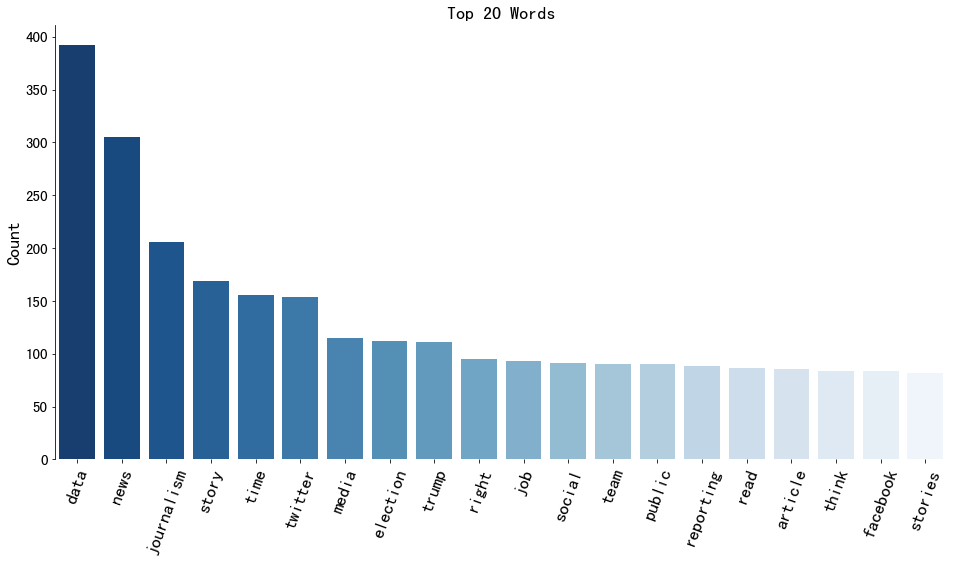

In [41]:
test=getText('test.txt')  
words =test.split() 
word_list = stop_words(words)
word_count(word_list)

# 放大了字体到18号
# 调整了字体角度 不至于重叠

# What is the frequency of other words in the tweet text, what can we find out from them?

We originally wanted to look for words like "coding" and "programming", but it is clear that it is difficult to find them in the picture below. Does this mean that programming is not important in data journalism? We may need to distinguish two words “data” and “programming”. Those are similar but different concepts.

/Users/lichenxi/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


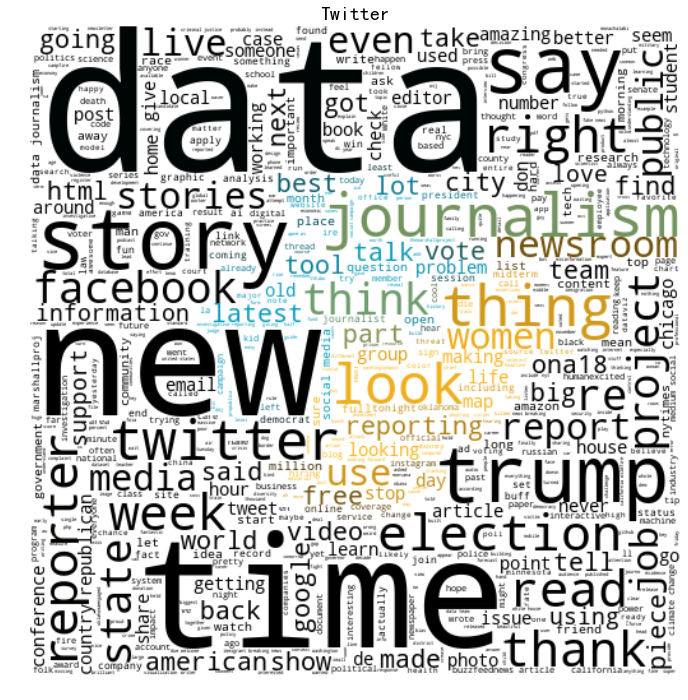

In [180]:
cloud_words(word_list)

# Job description analysis

In [87]:
dfs= pd.read_csv("1.5 new-selected-jobs.csv")
dfs.head()

,Title,Company,Location,Post_Date,URL,Current Status,Source,Description,Real
0,Senior Data Scientist - Machine Learning Engineer,IBM,United States,2018-11-11 17:39:58,https://www.indeed.com/viewjob?jk=cefa79152283...,NaN,indeed,Job Description\nWe are in a data science rena...,True
1,Data PR Communications Specialist,Zillow Group,"Seattle, WA 98101 (Downtown area)",2018-11-10 17:38:26,https://www.indeed.com/viewjob?jk=6aec7850bfad...,NaN,indeed,Desired: Public RelationsAP StyleAbout the tea...,True
2,Head of Data Solutions,Dow Jones,"New York, NY 10176 (Murray Hill area)",2018-11-10 17:38:13,https://www.indeed.com/viewjob?jk=f244217057ac...,NaN,indeed,Job Description:\nThe Wall Street Journal seek...,True
3,Ad Age Data Reporter,Crain Communications,"New York, NY",2018-11-10 17:37:46,https://www.indeed.com/viewjob?jk=4fdfc2e52ab8...,NaN,indeed,Job Details\nDescription\nAd Age is looking fo...,True
4,Global Food Analyst,Mintel,"Chicago, IL",2018-11-10 17:37:21,https://www.indeed.com/viewjob?jk=2a84759b39c2...,NaN,indeed,Desired: PackagingMintel is an international l...,True


In [89]:
# 文本处理
dfs_all_word =[]
for i in dfs["Description"]:
    dfs_all_word.append(i)

f = open('dfs.txt','w')
for i in dfs_all_word:
    f.write(i)

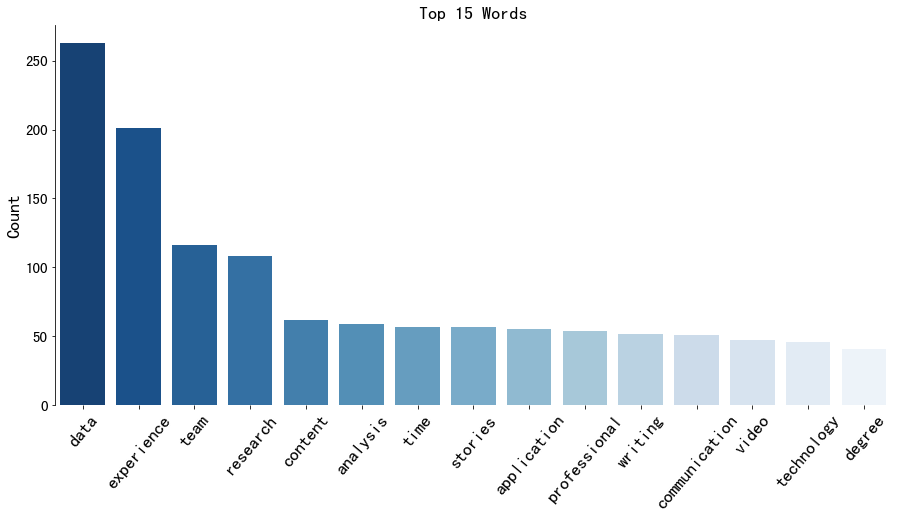

In [97]:
# TOP15的重要技能
test=getText('dfs.txt')  
words =test.split()
word_list = stop_words(words)
word_count(word_list)